In [1]:
from datetime import datetime
import matplotlib.pyplot as plt

import numpy as np
from finmc.calc.option import opt_price_mc

from src.models.aes import HestonAESMC
from src.models.basic import HestonMCBasic
from src.models.better import HestonMCBetter, HestonMCMilstein
from src.models.best import HestonBestMC
from src.models.closed import price_vanilla_call

In [3]:
# Rate Curve
times = np.array([0.0, 5.0])
rates = np.array([0.0, 0.0])
discount_data = ("ZERO_RATES", np.column_stack((times, rates)))

# Forward Curve
ticker = "EQ"
spot = 100.0
div_rate = 0.0
fwds = spot * np.exp((rates - div_rate) * times)
fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

pricing_datetime = datetime(2023, 12, 31)
dataset = {
    "BASE": "USD",
    "ASSETS": {"USD": discount_data, ticker: fwd_data},
    "MC": {
        "PATHS": 100_000,
        "TIMESTEP": 1 / 100,
        "SEED": 1,
    },
    "HESTON": {
        "ASSET": ticker,
        "INITIAL_VAR": 0.04,
        "LONG_VAR": 0.04,
        "VOL_OF_VOL": 0.8,
        "MEANREV": 1.0,
        "CORRELATION": -0.9,
    },
}

In [4]:
# Contract Terms
strike = 100
maturity = 1.0

In [5]:
# Closed form price
ref_price, _ = price_vanilla_call(
    strike,
    maturity,
    ticker,
    dataset,
)
print(f"ref_price: {ref_price:11.6f}")

ref_price:    5.553861


In [7]:
# Create four different models, calculate price, and error
models = {
    "Basic": HestonMCBasic,
    "AES": HestonAESMC,
    "Better": HestonMCBetter,
    "Milstein": HestonMCMilstein,
    "Best": HestonBestMC, 
}

for model_name, model_cls in models.items():
    model = model_cls(dataset)
    price = opt_price_mc(strike, maturity, "Call", ticker, model)
    print(f"{model_name:20s}: {price:11.6f} {price - ref_price:+11.6f}")

Basic               :    5.660415   +0.106554
AES                 :    5.536037   -0.017824
Better              :    5.633567   +0.079706
Milstein            :    5.660967   +0.107106
Best                :    7.865870   +2.312008


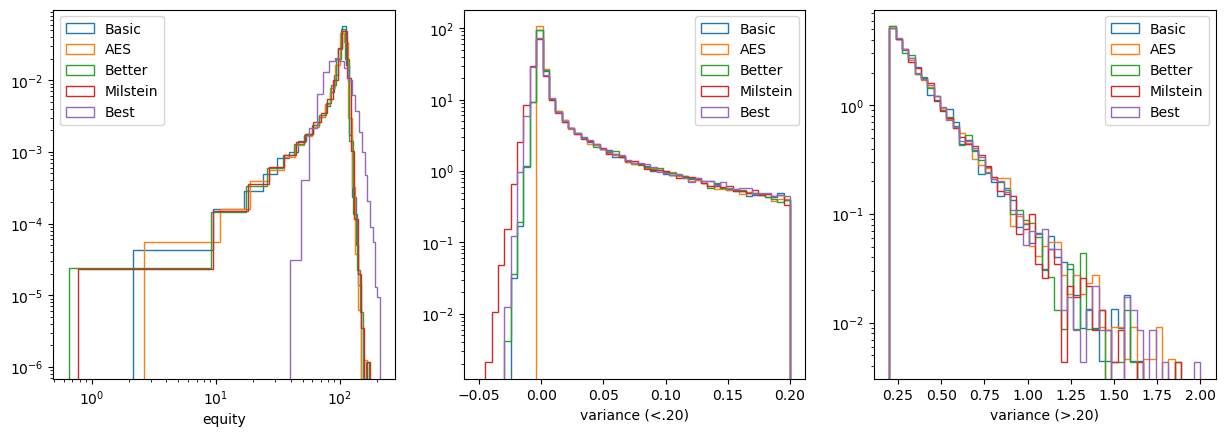

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)

for model_name, model_cls in models.items():
    model = model_cls(dataset)
    model.reset()
    model.advance(maturity)
    eq_vals = model.get_value(ticker)
    var_vals = model.get_value("variance")

    ax1.hist(
        eq_vals,
        bins=20,
        histtype="step",
        label=model_name,
        density=True,
    )
    ax1.set_xlabel("equity")
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.legend()

    ax2.hist(
        var_vals,
        bins=np.linspace(-0.05, 0.20, 50),
        histtype="step",
        label=model_name,
        density=True,
    )
    ax2.set_xlabel("variance (<.20)")
    ax2.set_yscale("log")
    ax2.legend()

    ax3.hist(
        var_vals,
        bins=np.linspace(0.20, 2.0, 50),
        histtype="step",
        label=model_name,
        density=True,
    )
    ax3.set_xlabel("variance (>.20)")
    ax3.set_yscale("log")
    ax3.legend()

Model: Basic
x_vec (log stock prices): [ 0.12071513  0.11364483 -0.00918118  0.12433796 -0.05641419]...
v_vec (variance): [-0.0013213   0.01155041 -0.00098812  0.01860754 -0.00489207]...



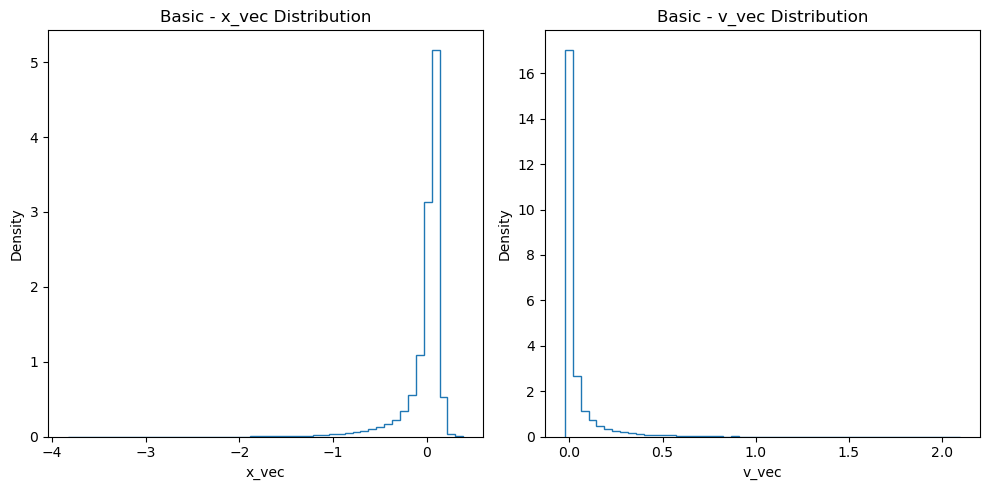

Model: AES
x_vec (log stock prices): [ 0.0546985   0.03078108  0.00826797  0.07778923 -0.0941363 ]...
v_vec (variance): [1.93460273e-03 1.97533814e-03 8.41158696e-02 1.90199789e-08
 9.34095240e-02]...



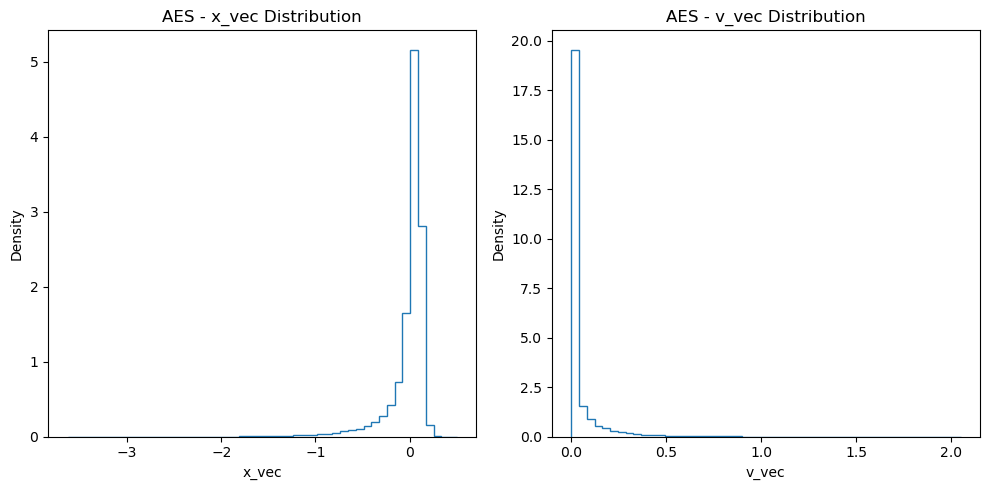

Model: Better
x_vec (log stock prices): [0.0814156  0.12248266 0.01579448 0.09390545 0.08001606]...
v_vec (variance): [ 2.06329085e-02 -9.74488995e-04  2.06760323e-02  3.74578658e-03
 -8.13863991e-05]...



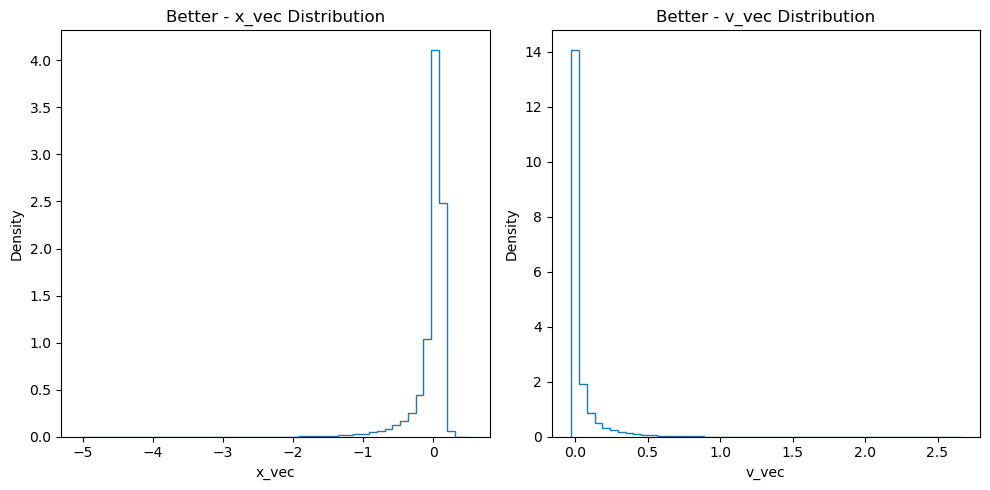

Model: Milstein
x_vec (log stock prices): [0.12556428 0.11153682 0.04067625 0.09206992 0.05692903]...
v_vec (variance): [-0.00157644 -0.00088712  0.02587222  0.00804857 -0.00195765]...



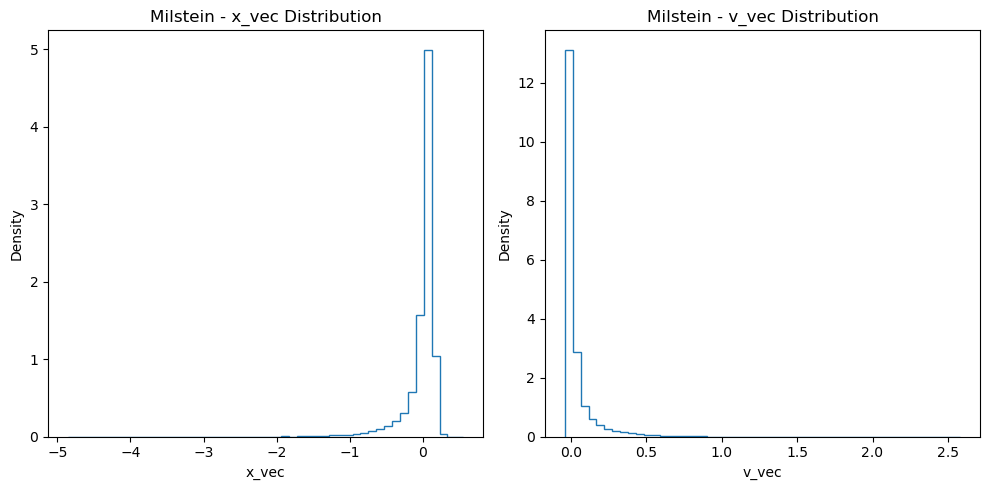

Model: Best
x_vec (log stock prices): [-0.05413498 -0.30642189 -0.16486541 -0.01021437 -0.21064401]...
v_vec (variance): [-0.00264654 -0.00243119 -0.00567344  0.00082842 -0.00403776]...



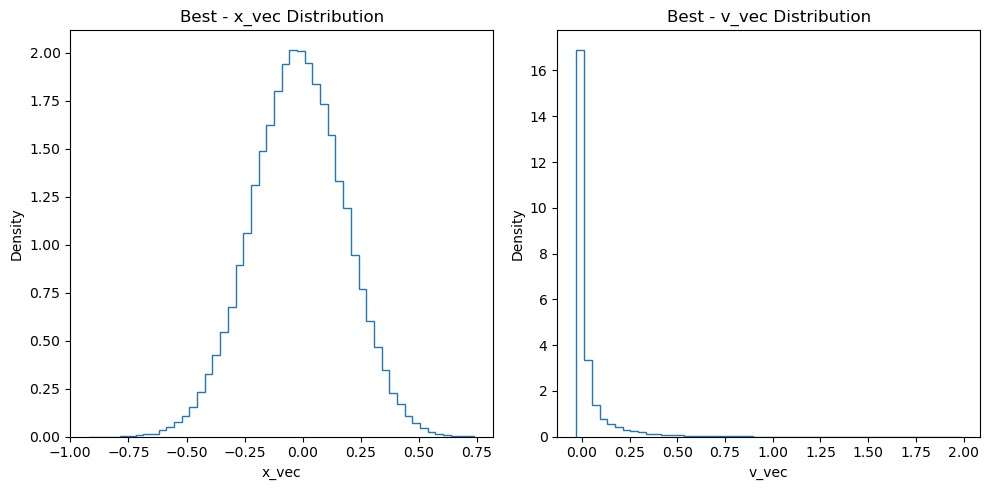

In [9]:
# Run simulations and capture internal states
for model_name, model_cls in models.items():
    model = model_cls(dataset)
    model.reset()
    model.advance(1.0)  

    # Access internal states
    x_vec = model.x_vec
    v_vec = model.v_vec if hasattr(model, 'v_vec') else model.v  # v_vec for most, v for AES

    # Output the internal states
    print(f"Model: {model_name}")
    print(f"x_vec (log stock prices): {x_vec[:5]}...")  # Show first 5 values 
    print(f"v_vec (variance): {v_vec[:5]}...\n")  # Show first 5 values 

    # Optional: Plot the distributions of x_vec and v_vec
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.hist(x_vec, bins=50, density=True, histtype='step', label=f'{model_name} x_vec')
    plt.title(f'{model_name} - x_vec Distribution')
    plt.xlabel('x_vec')
    plt.ylabel('Density')

    plt.subplot(1, 2, 2)
    plt.hist(v_vec, bins=50, density=True, histtype='step', label=f'{model_name} v_vec')
    plt.title(f'{model_name} - v_vec Distribution')
    plt.xlabel('v_vec')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
